# Analysis of Device Data
## Dataset Characteristics
This dataset has 1.95M instances and 51 attributes. The instances correspond to 822 sites, which we interpret as 822 distinct ATM machines for which failure predictions are necessary.

We found that not all instances have values for all 51 attributes: only 50K of the 1.95M instances have complete data, and none of these instances correspond to a failure. Frequently missing attributes generally apply to machine configuration or the status of machine subcomponents. In the vast majority of records, only 22 attributes are reliably present. We categorized these attributes into three  classes -- event timing, location, and machine status. We summarize the attributes below:
* ***timing:*** Event Date, entry_dt, identifier
* ***location:*** Site ID, Site Type, Cluster, State, Region, City, Location Type, TakeOver, Site Class
* ***machine status:*** Status, SwitchResionID, Source Channel, Device Type, Status Type, isTickect2, calculated_one, failed_in_24, Tech Date, Cash Date

We have focused on machine status features in our analysis. Many of the technical specifications of these attributes are not well-documented. We concentrate on the attributes 'SwitchResionID' and 'Source Channel', which can be combined to determine a human-readable machine status message as well as provide some insight into the machine state. The 'calculated_one' attribute is used as an indicator of an error condition, and this flag is set for approximately 14K rows in the dataset. The 'failed_in_24' attribute is used as an indicator of an event which occurs in the 24-hour window preceding an error condition.

Using these attributes, we sketch our analysis which we present in greater detail below. First, we determine which machine statuses are the most frequent and reliable indicators of machine failure. Focusing on these failure cases, we investigate the events preceding each type of failure and motivate common failure trajectories seen in the dataset. We define a 'danger level' for each status code by binning the statuses by failure probability. Next, we mine frequent patterns in the 24 hours preceding a failure to find reliable patterns of machine activity that may provide early indicators of machine failure. Finally, we sketch a proposal for a simple hidden Markov model that could be used to provide a more refined characterization of the probability of a machine failure.

## Common Failure Cases
Henceforth, we refer to the pair of attributes (SwitchResionID, Source Channel) as a *status code* and for brevity refer to status codes by the SwitchResionID in the text. These status codes correspond to normal operation or an error state -- no status code is observed in both normal operation and error states. For clarity, we refer to a status code indicated an error state as an error code, and there are 35 such error codes in the dataset. We begin by analyzing the top error codes in the 13,795 failures seen in the dataset. 

At a high-level, the prominent failures correspond to two types of failures. The first type of failure results from errors related to the Dispenser or Cash Distributor (error codes 9016, 2311, 1026) and are associated with 7329 (53%) of the errors in the dataset. The second common type of failure results from issues with the card reader (error codes 1017, 2225, 2225, 2249, 1059, 1057) and account for 4115 (30%) of the errors. The histogram below provides an overview of the error frequencies of each status, as well as error frequencies for less frequent conditions ('Other')


## Clustering ATM Status Codes
We can extend our analysis by considering not only the status codes indicating errors, but also include status codes that occur soon before a failure. Perhaps the simplest metric is the probability that a particular status code is obsedved in the 24-hour window preceding a failure, or $P({\tt StatusCode}|{\tt Failure})$. We generate this metrics for status codes and find a set of status codes that have high overlap with the error codes previously identified.

One drawback of the simple failure probability metric is that it does not adequately account for status codes that occur frequently even in settings that do not indicate failure. A better metric is quantifying the log-odds ratio of the failure and non-failure settings. We formally define this quantity below. To simplify the computation, we demonstrate that this quantity is proportional to the joint probability multiplied by a constant. We omit the constant factor use this simpler, equivalent metric in our analysis.
$$\mbox{log}\frac{P({\tt StatusCode}|{\tt Failure})}{P({\tt StatusCode}|{\tt Normal})} = \mbox{log}\frac{P({\tt StatusCode}\cap{\tt Failure})}{P({\tt StatusCode}\cap{\tt Normal})} \cdot \frac{P({\tt Normal})}{P({\tt Failure})}$$ 

After computing the log probability of the ratio of failure to normal events, we generate a histogram of the status codes, seen below. Since the log value of non-failing status codes is negative infinity, we perform smoothing by assigning each status code a small probability of both success and failure. We observe data divides into roughly three clusters. The first cluster, corresponding to the codes in the interval (-15,-5) contains status codes that very rarely occur in the 24-hours prior to a failure. The second cluster, in the interval (-5,5) consists of status codes that occur in approximately even proportions in the failure and normal cases, and have low predictive power. Finally, the set of bars that have a log probability ratio greater than 5 and include 52 status codes occur substantially more frequently in failure cases than in normal operation. These status codes include the 35 error codes as well as other status codes that seem correlated with failure, for example status 2053 with log-odds ratio 7.959 and indicating the status 'Journal Backup and Reprint terminated.' Code to generate a complete list of predictive status codes is included in the appendix.

## Failure Trajectories
Identifying status codes that are highly correlated with failures is a first step to understanding failures, however a deeper question is why these failures occur. To provide a more detailed analysis of the failures, we generate *failure trajectories*. The most basic failure trajectory is determining the most probable events preceding a failure. 

We first construct a transition table to record the transitions between status codes in the dataset. We specify a time window of fifteen minutes, and only consider consecutive events that occur within this time window when recording transitions. Using this transition table, we are able to find the probability of the events preceding each failure status.  

To provide an example of the value of this analytical approach, we consider the predecessor events for errors related to the dispenser. These errors correspond to codes 9016, 2311, and 1026. One interesting observation is that even though these errors target share a common failure point, their causes differ. 
Looking at the most probable previous statuses for error code 9016 (Dispenser Fatal), we found that the highest value is code 9016 -- a machine will repeat this same error code with a delay of 10-15 seconds multiple times. Beyond this error repetition, the most common preceding status is 594, indicating a message to go out of service was received. 
For error code 2311 (Cash distributor has fatal problem), the most common cause is status 2215, indicating no notes were dispensed. 
Error 1026 has the opposite symptom (Too many notes dispensed), and the common predecessors are 'Cassette 1 warning' and 'Bill sensors not blocked by money stack'.

We provide code in the appendix to enable this type of analyis for all error codes (as well as other status codes)


## Frequent Patterns Found Prior to Failure
Understanding the events leading to failures allows us to determine the proximal causes for those failures. A deeper analysis can also identify more complex patterns that occur before the failure. Our analysis seeks to find the most frequent patterns occuring in the 24 hours preceding a failure. Each pattern consists of a series of observed status codes. By investigating these sequences of status codes, we can find more general patterns of events that are correlated with failures. 

Our code supports arbitrary pattern lengths, but considering patterns of five events, we find that there are some salient sequences. First, occurring 1582 times, we see sequences where the error code 9016 (Dispenser Fatal) occurs repeatedly. Next, we see 1036 patterns where of sequence 2111, 2137, 2110, 594, 509 which corresponds to a pattern where the sensors mode is switched to supervisory mode and the machine subsequently goes out of service. A third common pattern found that occurs in differing forms over 1500 times is one involving codes 151, 150, 510, 594, and 509. This corresponds to a lost connection to the ATM, and upon restoring connectivity the ATM reports an error condition, in response to which the ATM is placed out of service. More frequently, the connectivity is lost but the ATM does not report an error and returns to service.



## Training a Hidden Markov Model to Predict Failure States
Ultimately, the goal of analyzing this dataset is to build a model that can predict the severity of a machine's state and allow for preventive action to prevent failure. One proposed approach to this problem is to capture these differing levels of severity as a latent variable or hidden state of each machine. The sequence of observed events, in the form of machine status codes, allows us to update our beliefs of each machine's state, and correspondingly assess the likelihood of failure. 

Using the building blocks from the previous section, we can build a hidden Markov model for this dataset that implements these modeling goals. The model would be constructed with four hidden states, corresponding to low, moderate, high, and severe failure risks. The probability of each event (status code) would differ for each of these states, and be estimated from the data. Observing a new event would potentially trigger a transition between machine states, and after each event the model can provide a probability of each possible machine state.  The preceding sections, which implemented conditional probability estimates of status codes by state and transition probabilities between status codes, provide the building blocks for constructing such a hidden Markov model.


## Appendix
The last code block in this section sets up the dataset Each code block below is labeled based on the section in the report it corresponds to.

### Dataset Characteristics

In [2]:
# Data size
print 'There are %d instances and %d attributes\n' % atm.shape

#Number of ATMs
print 'The instances are distributed over %d unique Site IDs\n' % (atm['Site ID'].unique().size)

#Column names
print 'The attribute names are: ',atm.columns.values

#Instances with complete data:
print '\nDropping instances with incomplete data, we are left with %d instances\n' % (atm.dropna().shape[0])

#Attributes with incomplete data
print '%d attributes have null values\n' % atm.isnull().any()[atm.isnull().any()==True].index.size

#Columns without null values
print 'Dropping attributes that have null values, we are left with %d attributes\n' %\
    (atm.dropna(axis=1,how='any').shape[1])

#Number of failures:
print 'There are %d events corresponding to failures and %d events in a 24-hour window preceding a failure' %\
     (atm[atm['calculated_one']==1].shape[0],atm[atm['failed_in_24']==1].shape[0])

There are 1956767 instances and 51 attributes

The instances are distributed over 822 unique Site IDs

The attribute names are:  ['identifier' 'entry_dt' 'Site ID' 'Event Date' 'SwitchResionID'
 'Reserved_3' 'Card Reader Fitness' 'Purge Cassette Supply'
 'Encryptor Unit Fitness' 'Cassette1 Supply' 'Cassette2 Supply'
 'Cassette3 Supply' 'Cassette4 Supply' 'Deposit Fitness'
 'Merchant Diposit Fitness' 'Envelope Distributor Fitness'
 'Coin Distributor Fitness' 'Receipt printer Fitness' 'Log Printer Fitness'
 'A4 Printer Fitness' 'Passbook Printer Fitness' 'DPM Fitness'
 'BNA Device Fitness' 'BNA Supply' 'CHEQUE Scanner Fitness'
 'CHEQUE Scanner Supply' 'Voice Module Fitness' 'Camera Fitness'
 'Journal Paper Supply' 'Journal Ribbon Supply' 'Receipt Paper Supply'
 'Receipt Ribbon Supply' 'A4 Paper Supply' 'Site Type' 'Cluster' 'State'
 'Region' 'City' 'Location type' 'TakeOver' 'Status' 'Tech Date'
 'Cash Date' 'Site Class' 'Source Channel' 'Device Type' 'Status Type'
 'isTickect2' 'Machine

In [3]:
#Find the distinct values for categorical attributes
for col in atm.dropna(axis=1,how='any').columns: #atm.columns:
    if atm[col].unique().size < 10:
        print col, atm[col].unique()
    else: 
        print col, atm[col].unique().size

identifier 1956767
entry_dt 53
Site ID 822
Event Date 708032
SwitchResionID 177
Site Type ['Onsite' 'Offsite as Onsite' 'Offsite' 'Within Branch']
Cluster ['Karnataka & Goa' 'Rajasthan' 'Gujrat  Diu  Daman & DDR'
 'Odisha & Chattisgarh']
State ['Karnataka' 'Rajasthan' 'Gujarat' 'Odisha' 'Chhattisgarh' 'Goa']
Region 105
City 406
Location type ['Urban' 'Rural' 'Semi Urban']
TakeOver ['Takeover > 7 yr' 'New']
Status ['Cash Live']
Tech Date 341
Cash Date 343
Site Class ['Silver Plus' 'Gold' 'Bronze' 'Platinum' 'Silver']
Source Channel ['OPUSV1_DDC' 'FSSV1_NDC' 'OPUSV1_NDC' 'FISV1_DDC' 'FISV1_NDC']
Device Type 18
Status Type [1 0]
isTickect2 [1 0]
calculated_one [0 1]
failed_in_24 [0 1]


### Common Failure Cases

In [4]:
#compute the most common failures
for r in atm[atm['calculated_one']==1].groupby(by=('SwitchResionID','Source Channel')).\
            size().sort_values(ascending=False).head(20).iteritems():
    print 'status {0:20s} has {1:5d} associated failures and corresponds to status:\n\t {2}'.\
        format(r[0],r[1],reasons_table.loc[r[0][0],r[0][1]])

status (9016, 'OPUSV1_DDC') has  4669 associated failures and corresponds to status:
	 Dispenser Fatal
status (2311, 'OPUSV1_NDC') has  2356 associated failures and corresponds to status:
	 Cash distributor has fatal problem
status (1017, 'FISV1_DDC')  has  1374 associated failures and corresponds to status:
	 CARD READER WARNING
status (2225, 'OPUSV1_NDC') has  1227 associated failures and corresponds to status:
	 Card ReaderWriter Read error
status (2249, 'OPUSV1_NDC') has   797 associated failures and corresponds to status:
	 Card ReaderWriter Received unknown Mstatus
status (1059, 'OPUSV1_DDC') has   389 associated failures and corresponds to status:
	 Card is jammed on the read head
status (1057, 'OPUSV1_DDC') has   328 associated failures and corresponds to status:
	 Track 123 read error
status (1026, 'FISV1_NDC')  has   304 associated failures and corresponds to status:
	 CASSETTE 1  WARNING
status (1026, 'OPUSV1_DDC') has   304 associated failures and corresponds to status:
	 T

In [5]:
#Compute failure probability for each status code
print (atm.groupby(by=('SwitchResionID','Source Channel'))['calculated_one'].\
    value_counts(normalize=True).unstack().fillna(0)).loc[:,1].sort_values(ascending=False).head(36)

SwitchResionID  Source Channel
2193            OPUSV1_NDC        1
1019            OPUSV1_DDC        1
1026            FISV1_NDC         1
                OPUSV1_DDC        1
1027            FISV1_NDC         1
2310            OPUSV1_NDC        1
2307            OPUSV1_NDC        1
1027            OPUSV1_DDC        1
1028            FISV1_NDC         1
                OPUSV1_DDC        1
1031            OPUSV1_DDC        1
1034            OPUSV1_DDC        1
1057            OPUSV1_DDC        1
2249            OPUSV1_NDC        1
1058            OPUSV1_DDC        1
2225            OPUSV1_NDC        1
2216            OPUSV1_NDC        1
1059            OPUSV1_DDC        1
2198            OPUSV1_NDC        1
2192            OPUSV1_NDC        1
2190            OPUSV1_NDC        1
2186            OPUSV1_NDC        1
2185            OPUSV1_NDC        1
2184            OPUSV1_NDC        1
2179            OPUSV1_NDC        1
2177            OPUSV1_NDC        1
2176            OPUSV1_NDC       

In [6]:
top_failures = atm[atm['calculated_one']==1].\
    groupby(by=('SwitchResionID','Source Channel')).\
    size().sort_values(ascending=False).head(20)

In [7]:
for r in top_failures.iteritems():
    print 'status {0:20s} has {1:5d} associated failures\
 with message:\n\t {2}'.\
    format(r[0],r[1],reasons_table.loc[r[0][0],r[0][1]])

status (9016, 'OPUSV1_DDC') has  4669 associated failures with message:
	 Dispenser Fatal
status (2311, 'OPUSV1_NDC') has  2356 associated failures with message:
	 Cash distributor has fatal problem
status (1017, 'FISV1_DDC')  has  1374 associated failures with message:
	 CARD READER WARNING
status (2225, 'OPUSV1_NDC') has  1227 associated failures with message:
	 Card ReaderWriter Read error
status (2249, 'OPUSV1_NDC') has   797 associated failures with message:
	 Card ReaderWriter Received unknown Mstatus
status (1059, 'OPUSV1_DDC') has   389 associated failures with message:
	 Card is jammed on the read head
status (1057, 'OPUSV1_DDC') has   328 associated failures with message:
	 Track 123 read error
status (1026, 'FISV1_NDC')  has   304 associated failures with message:
	 CASSETTE 1  WARNING
status (1026, 'OPUSV1_DDC') has   304 associated failures with message:
	 Too many bills dispensed
status (2184, 'OPUSV1_NDC') has   285 associated failures with message:
	 CashHandler Operati

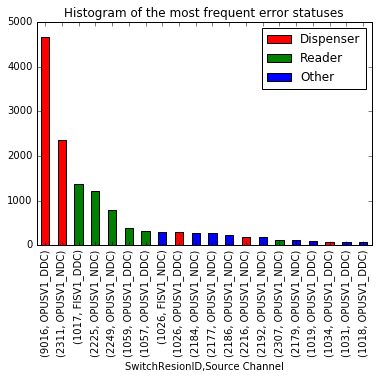

In [8]:
axes = top_failures.plot(kind='bar', color='rrgggggbrbbbrbgbbrbb')
plt.title('Histogram of the most frequent error statuses')
llabels = axes.get_legend_handles_labels()
llabels[0][0][0].set_label('Dispenser')
llabels[0][0][2].set_label('Reader')
llabels[0][0][7].set_label('Other')
plt.legend(labels=['Dispenser','Reader','Other'])

### Clustering ATM Status Codes

In [9]:
#Compute probability of failure in 24 hours when status code is present
print atm.groupby(by=('SwitchResionID','Source Channel'))['failed_in_24'].\
    value_counts(normalize=True).unstack().fillna(0)

failed_in_24                          0         1
SwitchResionID Source Channel                    
150            OPUSV1_DDC      0.889611  0.110389
151            OPUSV1_DDC      0.890977  0.109023
508            OPUSV1_DDC      0.887165  0.112835
509            OPUSV1_DDC      0.838901  0.161099
510            OPUSV1_DDC      0.839616  0.160384
594            OPUSV1_DDC      0.835039  0.164961
595            OPUSV1_DDC      0.837837  0.162163
1011           FISV1_DDC       0.702273  0.297727
               FISV1_NDC       0.702273  0.297727
               OPUSV1_DDC      0.702273  0.297727
1012           FISV1_DDC       0.976744  0.023256
               OPUSV1_DDC      0.976744  0.023256
1013           FISV1_DDC       0.163522  0.836478
               FISV1_NDC       0.163522  0.836478
               OPUSV1_DDC      0.163522  0.836478
1014           FISV1_DDC       0.004219  0.995781
               FISV1_NDC       0.004219  0.995781
               OPUSV1_DDC      0.004219  0.995781


In [10]:
#Compute probability of status code in failure and normal conditions
atm_failures = atm.loc[atm['failed_in_24']==1]
atm_normal = atm.loc[atm['failed_in_24']==0]
p_status_failure = atm_failures.loc[:,['SwitchResionID','Source Channel',\
    'failed_in_24']].groupby(by=('SwitchResionID','Source Channel')).\
    apply( lambda x: (0.0+len(x))/len(atm_failures) )
p_status_normal = atm_normal.loc[:,['SwitchResionID','Source Channel',\
    'failed_in_24']].groupby(by=('SwitchResionID','Source Channel')).\
    apply( lambda x: (0.0+len(x))/len(atm_normal) )

In [11]:
status_logprob = pd.Series(index=status_codes)
for status_code in status_codes:
    normal = 0.000000001
    failure = 0.000000001
    try: normal += p_status_normal[status_code]
    except: pass
    try: failure += p_status_failure[status_code]
    except: pass
    status_logprob.ix[status_code]= max(np.log(failure/normal),-25)

In [12]:
for r in status_logprob.sort_values(ascending=False).head(15).iteritems():
    print 'status {0:20s} has log-odds ratio {1:3.3f} with message\n\t {2}'\
    .format(r[0],r[1],reasons_table.loc[r[0][0],r[0][1]])

status (9016, 'OPUSV1_DDC') has log-odds ratio 16.408 with message
	 Dispenser Fatal
status (2311, 'OPUSV1_NDC') has log-odds ratio 15.724 with message
	 Cash distributor has fatal problem
status (1017, 'OPUSV1_DDC') has log-odds ratio 15.185 with message
	 Feed failure from cassette
status (1017, 'FISV1_DDC')  has log-odds ratio 15.185 with message
	 CARD READER WARNING
status (2225, 'OPUSV1_NDC') has log-odds ratio 15.072 with message
	 Card ReaderWriter Read error
status (2249, 'OPUSV1_NDC') has log-odds ratio 14.640 with message
	 Card ReaderWriter Received unknown Mstatus
status (1059, 'OPUSV1_DDC') has log-odds ratio 13.923 with message
	 Card is jammed on the read head
status (1057, 'OPUSV1_DDC') has log-odds ratio 13.752 with message
	 Track 123 read error
status (1026, 'FISV1_NDC')  has log-odds ratio 13.676 with message
	 CASSETTE 1  WARNING
status (1026, 'OPUSV1_DDC') has log-odds ratio 13.676 with message
	 Too many bills dispensed
status (2184, 'OPUSV1_NDC') has log-odds r

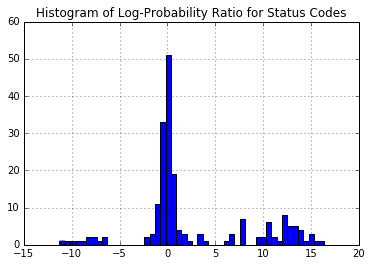

In [13]:
status_logprob.hist(bins=50)
plt.title('Histogram of Log-Probability Ratio for Status Codes')

In [14]:
print 'There are %d status codes with log-probability over 5'\
% len(status_logprob[status_logprob>5])

There are 52 status codes with log-probability over 5


### Failure Trajectories

In [15]:
transition_count = pd.DataFrame(index=status_codes,\
                                columns=status_codes).fillna(0)
atm_sites = atm.sort_values(by='Event Date').groupby('Site ID')
for group in atm_sites:
    prevSC = None
    prevTime = None
    for currRec in group[1].loc[:,['SwitchResionID',\
        'Source Channel', 'Event Date']].iterrows():
        currSC = (currRec[1]['SwitchResionID'],\
                  currRec[1]['Source Channel'])
        if prevSC is not None:
            if currRec[1]['Event Date']-prevTime <\
                dt.timedelta(minutes=15):
                transition_count.ix[prevSC,currSC]+=1
        prevSC = currSC
        prevTime = currRec[1]['Event Date']

In [16]:
conditional_previous=transition_count.\
    apply(lambda x: x/transition_count.sum(axis=0),axis=1)
for error in top_failures.head(10).iteritems():
    print '{}\t{}'.format(error[0],reasons_table.loc[error[0]])
    for rec in conditional_previous[error[0]].dropna().\
    sort_values(ascending=False).head(3).iteritems():
        print '\t{0:03.3f}\t{2}: {1}'.format\
        (rec[1],reasons_table.loc[rec[0]], rec[0])

(9016, 'OPUSV1_DDC')	Dispenser Fatal
	0.737	(9016, 'OPUSV1_DDC'): Dispenser Fatal
	0.053	(594, 'OPUSV1_DDC'): Go Out Of Service message sent to the ATM
	0.044	(508, 'OPUSV1_DDC'): ATM is in service
(2311, 'OPUSV1_NDC')	Cash distributor has fatal problem
	0.331	(2215, 'OPUSV1_NDC'): CashHandler No notes dispensed
	0.211	(509, 'OPUSV1_DDC'): ATM is out of service
	0.075	(508, 'OPUSV1_DDC'): ATM is in service
(1017, 'FISV1_DDC')	CARD READER WARNING
	0.405	(1017, 'OPUSV1_DDC'): Feed failure from cassette
	0.258	(1013, 'OPUSV1_DDC'): Bill sensors are not blocked by a money stack
	0.133	(1013, 'FISV1_DDC'): 3RD CASSETTE  LOW ON CASH
(2225, 'OPUSV1_NDC')	Card ReaderWriter Read error
	0.830	(2305, 'OPUSV1_NDC'): Card reader has major error It Continues to work
	0.074	(2225, 'OPUSV1_NDC'): Card ReaderWriter Read error
	0.062	(2235, 'OPUSV1_NDC'): Card ReaderWriter Card in throatposs customer tamper
(2249, 'OPUSV1_NDC')	Card ReaderWriter Received unknown Mstatus
	0.446	(2305, 'OPUSV1_NDC'): Card

### Frequent Patterns Prior to Failure

In [17]:
def window_pattern(data, win):
    atm_sites = data.sort_values(by='Event Date').groupby('Site ID')
    seq = deque([])
    freq = Counter()
    for group in atm_sites:
        for currRec in group[1].loc[:,['SwitchResionID',\
        'Source Channel', 'Event Date']].iterrows():
            if len(seq) == win:
                freq[tuple(seq)]+=1
                seq.popleft()
            seq.append(tuple([currRec[1]['SwitchResionID'],\
                      currRec[1]['Source Channel']]))
        freq[tuple(seq)]+=1
    return freq

In [18]:
for pat in window_pattern(atm_failures, 5).most_common(10):
    print pat[1]
    for rec in pat[0]:
        print '\t{}\t{}'.format(rec,reasons_table.loc[rec])
    print '\n'              

1582
	(9016, 'OPUSV1_DDC')	Dispenser Fatal
	(9016, 'OPUSV1_DDC')	Dispenser Fatal
	(9016, 'OPUSV1_DDC')	Dispenser Fatal
	(9016, 'OPUSV1_DDC')	Dispenser Fatal
	(9016, 'OPUSV1_DDC')	Dispenser Fatal


1036
	(2111, 'OPUSV1_NDC')	Sensors Mode switch moved to supervisory mode
	(2137, 'OPUSV1_NDC')	Supervisor Keys Key presssed from Main Menu
	(2110, 'OPUSV1_NDC')	Sensors Mode switch moved to normal mode
	(594, 'OPUSV1_DDC')	Go Out Of Service message sent to the ATM
	(509, 'OPUSV1_DDC')	ATM is out of service


898
	(2111, 'OPUSV1_NDC')	Sensors Mode switch moved to supervisory mode
	(2137, 'OPUSV1_NDC')	Supervisor Keys Key presssed from Main Menu
	(594, 'OPUSV1_DDC')	Go Out Of Service message sent to the ATM
	(2110, 'OPUSV1_NDC')	Sensors Mode switch moved to normal mode
	(509, 'OPUSV1_DDC')	ATM is out of service


892
	(2138, 'OPUSV1_NDC')	Supervisor Keys Key presssed from Replenish Menu
	(2138, 'OPUSV1_NDC')	Supervisor Keys Key presssed from Replenish Menu
	(2138, 'OPUSV1_NDC')	Supervisor Keys 

### Setting up the Data Analysis Environment

In [1]:
%matplotlib inline
from sklearn import datasets, preprocessing, cross_validation,\
    feature_extraction, linear_model, svm, metrics, ensemble
import numpy as np
import datetime as dt
import pandas as pd
import ast
import matplotlib.pyplot as plt
from collections import Counter, deque
datapath = 'file://data.csv'
statuscodepath = 'file:///Users.../SwitchStatusCodes.csv'
atm  = pd.read_csv(datapath, header=0)
atm['Event Date']=pd.to_datetime(atm['Event Date'])
reasons  = pd.read_csv(statuscodepath, header=0, skipinitialspace=True, error_bad_lines=False, index_col=False)
reasons_table = pd.DataFrame()
for x in reasons.loc[:,['SwitchResionID','SourceChannel for Different Switches','Description']].iterrows():
    reasons_table.loc[x[1]['SwitchResionID'],x[1]['SourceChannel for Different Switches']]=x[1]['Description']
status_codes = [x for x in atm.groupby(by=('SwitchResionID','Source Channel')).groups.iterkeys()]